In [122]:
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torch import optim
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np
import argparse

In [119]:
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

---------

In [16]:
dat = np.load("data/mnist_sequence1_sample_5distortions5x5.npz")
X_train, y_train = dat["X_train"], dat["y_train"]
X_train = X_train.reshape((10000, 1, 40, 40))
print X_train.shape, y_train.shape

(10000, 1, 40, 40) (10000, 1)


In [124]:
def iterator(X_full, y_full, bs, shuffle=True, use_torch=True):
    if shuffle:
        idxs = np.arange(0, X_full.shape[0])
        np.random.shuffle(idxs)
    X_full, y_full = X_full[idxs], y_full[idxs]
    for b in range(0, X_full.shape[0] // bs):
        X_batch, y_batch = X_full[b*bs:(b+1)*bs], y_full[b*bs:(b+1)*bs].flatten()
        #print X_batch.shape, y_batch.shape
        if use_torch:
            X_batch = Variable(torch.from_numpy(X_batch).float())
            y_batch = Variable(torch.from_numpy(y_batch).long())
        yield X_batch, y_batch

------

Define the model here. It must be split up into a `classifier` and a `features` part in order for the GradCam code to work.

In [59]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [130]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, stride=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, stride=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, 3, stride=2),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(4)
        )
        self.classifier = torch.nn.Sequential(
            Flatten(),
            torch.nn.Linear(128, 10)
        )
    def forward(self, x):
        features = self.features(x)
        classifier = self.classifier(features)
        return classifier

In [131]:
model = Model()
print model

Model (
  (features): Sequential (
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU ()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU ()
    (9): AvgPool2d (size=4, stride=4, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (classifier): Sequential (
    (0): Flatten (
    )
    (1): Linear (128 -> 10)
  )
)


In [132]:
optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model.train()
for epoch in range(10):
    losses = []
    for X_batch, y_batch in iterator(X_train, y_train, 32):
        model.zero_grad()
        outputs = F.log_softmax(model(X_batch))
        nll_loss = F.nll_loss(outputs, y_batch)
        losses.append(nll_loss.data[0])
        nll_loss.backward()
        optimiser.step()
    print np.mean(losses)

1.92030773904
1.22334914368
0.797753447523
0.546787633728
0.400330965622
0.328635177551
0.262105468159
0.220625925964
0.180284816473


KeyboardInterrupt: 

In [140]:
model.eval()

Model (
  (features): Sequential (
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU ()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU ()
    (9): AvgPool2d (size=4, stride=4, padding=0, ceil_mode=False, count_include_pad=True)
  )
  (classifier): Sequential (
    (0): Flatten (
    )
    (1): Linear (128 -> 10)
  )
)

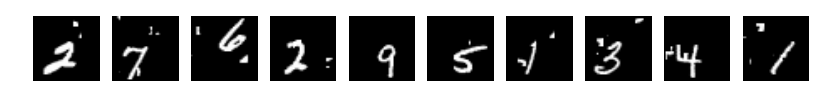

In [150]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_batch.data.numpy()[i][0], cmap="gray")
    plt.axis('off')

In [156]:
np.argmax(model(X_batch).data.numpy(),axis=1)[0:10]

array([2, 7, 6, 2, 9, 5, 1, 3, 4, 1])

In [157]:
import grad_cam

In [173]:
gc = grad_cam.GradCam(model, target_layer_names=["8"], use_cuda=False)

torch.Size([1, 128, 4, 4]) torch.Size([128, 1, 1])
torch.Size([1, 128, 4, 4]) torch.Size([128, 1, 1])
torch.Size([1, 128, 4, 4]) torch.Size([128, 1, 1])
torch.Size([1, 128, 4, 4]) torch.Size([128, 1, 1])
torch.Size([1, 128, 4, 4]) torch.Size([128, 1, 1])
torch.Size([1, 128, 4, 4]) torch.Size([128, 1, 1])
torch.Size([1, 128, 4, 4]) torch.Size([128, 1, 1])
torch.Size([1, 128, 4, 4]) torch.Size([128, 1, 1])
torch.Size([1, 128, 4, 4]) torch.Size([128, 1, 1])
torch.Size([1, 128, 4, 4]) torch.Size([128, 1, 1])


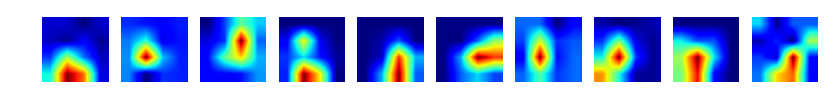

In [177]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(gc(X_batch[i:i+1], None))
    plt.axis('off')